In [1]:
from __future__ import print_function
import os
import sys
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ["RNB_PLANNING_DIR"], "src"))

## Prepare single robot scene

In [2]:
from pkg.utils.test_scripts import *
from pkg.controller.robot_config import *

ROBOT_TYPE = RobotType.panda
ROBOT_NAME, TOOL_LINK, TOOL_XYZ, TOOL_RPY, HOME_POSE, GRIP_DEPTH = get_single_robot_params(ROBOT_TYPE)
s_buillder, pscene = prepare_single_robot_scene(
    ROBOT_TYPE=ROBOT_TYPE, ROBOT_NAME=ROBOT_NAME, TOOL_LINK=TOOL_LINK, TOOL_XYZ=TOOL_XYZ, TOOL_RPY=TOOL_RPY)
gscene = pscene.gscene

connection command:
panda0: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


## Prepare dummy object

In [3]:
gscene.create_safe(gtype=GEOTYPE.BOX, name="obj", link_name="base_link", 
                   dims=(0.05,0.05,0.05), center=(0,0,0.025), rpy=(0,0,0), fixed=False)

from pkg.planning.constraint.constraint_subject import BoxObject
obj = pscene.create_subject(oname="obj", gname="obj", _type=BoxObject)
from pkg.planning.constraint.constraint_actor import Gripper2Tool
grip = pscene.create_binder(bname="grip0", gname="grip0", _type=Gripper2Tool, point=(0,0,0))

## Prepare planner

In [4]:
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene=pscene)

In [5]:
from pkg.planning.filtering.reach_filter import ReachChecker
rcheck = ReachChecker(pscene)

sheight = rcheck.shoulder_height_dict[ROBOT_NAME]
sreach = rcheck.shoulder_reach_dict[ROBOT_NAME]

## check with ReachTrainer and test dataset

In [42]:
from pkg.planning.filtering.reach_filter import ReachTrainer, features2T, xyzquat2features, T2features, to_featurevec
rtrain = ReachTrainer(scene_builder=s_buillder)

In [44]:
goalpose_list, success_list = rtrain.load_data(ROBOT_TYPE, "test")
goalpose_list = np.array(goalpose_list)

In [47]:
gtimer = GlobalTimer.instance()
gtimer.reset()
T_list = []
result_list = []
for goalpose in goalpose_list:
    features = xyzquat2features(goalpose, rcheck.shoulder_height_dict[ROBOT_NAME])
    T = features2T(*features)
    xyz = T[:3,3]
    orientation_mat = T[:3,:3]
    Tloal = SE3(orientation_mat, xyz)
    with gtimer.block("ReachChecker"):
        rfeas = rcheck.check_T_loal(grip, obj, Tloal, pscene.combined_robot.home_dict)
    xyz, quat = T2xyzquat(Tloal)
    for _ in range(30):
        ikres = mplan.planner.solve_ik_py(ROBOT_NAME, xyz + quat, self_collision=True) is not None
        if ikres:
            break
    T_list.append(Tloal)
    result_list.append((rfeas, ikres))
result_list = np.array(result_list)
print("ik sanity: {:.04}".format(np.mean(result_list[:,1]==success_list)*100))
print("accuracy : {:.04}".format(np.mean(result_list[:,1]==result_list[:,0])*100))
print(gtimer)

ik sanity: 99.42
accuracy : 93.72
ReachChecker: 	1185.6 ms/5000 = 0.2 ms (0.212/0.42)



```
ik sanity: 97.32
accuracy : 92.26
ReachChecker: 	1128.9 ms/5000 = 0.2 ms (0.207/0.375)

```

## Test new data

In [48]:
gtimer = GlobalTimer.instance()
gtimer.reset()
T_list = []
result_list_new = []
featurevec_list_new = []
for i in range(1000):
    while True:
        xyz_shoulder = np.random.uniform(-0.85, 0.85, size=3)
        sradii = np.linalg.norm(xyz_shoulder)
        xyz = xyz_shoulder + [0,0,sheight]
        if np.linalg.norm(xyz[:2])>0.2 and sradii<sreach:
            break
#     rpy = np.random.uniform(0, np.pi*2, size=3)
#     R = Rot_rpy(rpy)
    radius, theta, height = cart2cyl(*xyz)
    azimuth_loc = np.random.uniform(-np.pi, np.pi)
    zenith = np.arccos(np.random.uniform(-np.cos(0), -np.cos(np.pi)))
    hori_bak = (azimuth_loc, zenith)
    R = hori2mat(azimuth_loc=azimuth_loc, zenith=zenith, theta=theta)
#     gscene.add_highlight_axis(hl_key="rc", name="a%03d"%i, link_name="base_link", center=xyz, orientation_mat=R,
#                              dims=(0.2,0.005,0.005))
    R = np.matmul(R, Rot_axis(3, np.random.uniform(-np.pi, np.pi)))
#     gscene.add_highlight_axis(hl_key="rc", name="b%03d"%i, link_name="base_link", center=xyz, orientation_mat=R,
#                              dims=(0.1,0.02,0.02))
    hori_rgn = mat2hori(R, theta=theta)
    assert np.linalg.norm(np.subtract(hori_bak, hori_rgn)) < 1e-6, "z rotation makes unexpected change in horizonotal coordinates"
    Tloal = SE3(R, xyz)
    
    features = T2features(Tloal, sheight)
    featurevec = to_featurevec(*features)
    featurevec_list_new.append(featurevec)
    with gtimer.block("ReachChecker"):
        rfeas = rcheck.check_T_loal(grip, obj, Tloal, pscene.combined_robot.home_dict)
    xyz, quat = T2xyzquat(Tloal)
    for _ in range(30):
        ikQ = mplan.planner.solve_ik_py(ROBOT_NAME, xyz + quat, self_collision=True)
        ikres = ikQ is not None
        if ikres:
            break
#     gscene.add_highlight_axis(hl_key="rc", name="%03d"%i, link_name="base_link", center=xyz, orientation_mat=R, axis="y",
#                              color=np.add((1,0,0,1) if rfeas else (0,0,0,1), (0,0,1,0) if ikres else (0,0,0,0)),
#                              dims=(0.05,0.005,0.005) if rfeas==ikres else (0.1,0.01,0.01))
    T_list.append(Tloal)
    result_list_new.append((rfeas, ikres))
#     if ikres:
#         gscene.show_pose(ikQ)
#         break
result_list_new = np.array(result_list_new)
featurevec_list_new = np.array(featurevec_list_new)
print("accuracy : {:.04}".format(np.mean(result_list_new[:,1]==result_list_new[:,0])*100))
print(gtimer)

accuracy : 94.8
ReachChecker: 	241.1 ms/1000 = 0.2 ms (0.217/0.491)



## plot feature vector depending on TP/FP/FN/TN

In [49]:
idx_tp_n = np.where(np.logical_and(result_list_new[:,0], result_list_new[:,1]))[0]
idx_fp_n = np.where(np.logical_and(result_list_new[:,0], np.logical_not(result_list_new[:,1])))[0]
idx_fn_n = np.where(np.logical_and(np.logical_not(result_list_new[:,0]), result_list_new[:,1]))[0]
idx_tn_n = np.where(np.logical_and(np.logical_not(result_list_new[:,0]), np.logical_not(result_list_new[:,1])))[0]
print("TP/FP/FN/TN: {}/{}/{}/{}".format(len(idx_tp_n), len(idx_fp_n), len(idx_fn_n), len(idx_tn_n)))

idx_tp = np.where(np.logical_and(result_list[:,0], result_list[:,1]))[0]
idx_fp = np.where(np.logical_and(result_list[:,0], np.logical_not(result_list[:,1])))[0]
idx_fn = np.where(np.logical_and(np.logical_not(result_list[:,0]), result_list[:,1]))[0]
idx_tn = np.where(np.logical_and(np.logical_not(result_list[:,0]), np.logical_not(result_list[:,1])))[0]
print("TP/FP/FN/TN: {}/{}/{}/{}".format(len(idx_tp), len(idx_fp), len(idx_fn), len(idx_tn)))

TP/FP/FN/TN: 611/36/16/337
TP/FP/FN/TN: 2944/203/111/1742


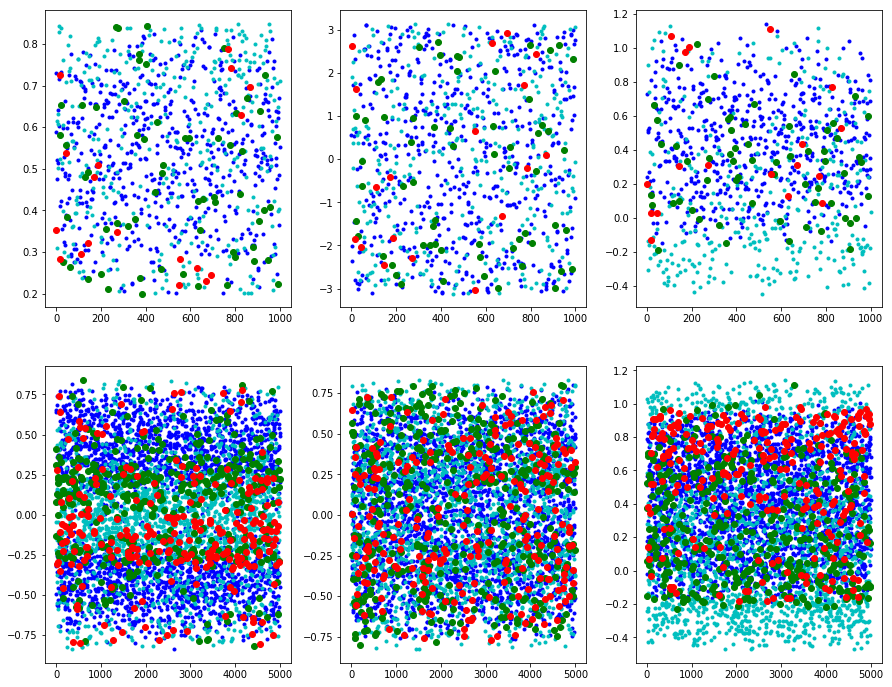

In [18]:
_ = plt.figure(figsize=(15,12))
_ = plt.subplot(2,3,1)
_ = plt.plot(idx_tp_n, featurevec_list_new[idx_tp_n,0], 'b.')
_ = plt.plot(idx_tn_n, featurevec_list_new[idx_tn_n,0], 'c.')
_ = plt.plot(idx_fp_n, featurevec_list_new[idx_fp_n,0], 'go')
_ = plt.plot(idx_fn_n, featurevec_list_new[idx_fn_n,0], 'ro')
_ = plt.subplot(2,3,2)
_ = plt.plot(idx_tp_n, featurevec_list_new[idx_tp_n,1], 'b.')
_ = plt.plot(idx_tn_n, featurevec_list_new[idx_tn_n,1], 'c.')
_ = plt.plot(idx_fp_n, featurevec_list_new[idx_fp_n,1], 'go')
_ = plt.plot(idx_fn_n, featurevec_list_new[idx_fn_n,1], 'ro')
_ = plt.subplot(2,3,3)
_ = plt.plot(idx_tp_n, featurevec_list_new[idx_tp_n,2], 'b.')
_ = plt.plot(idx_tn_n, featurevec_list_new[idx_tn_n,2], 'c.')
_ = plt.plot(idx_fp_n, featurevec_list_new[idx_fp_n,2], 'go')
_ = plt.plot(idx_fn_n, featurevec_list_new[idx_fn_n,2], 'ro')

_ = plt.subplot(2,3,4)
_ = plt.plot(idx_tp, featurevec_list[idx_tp,0], 'b.')
_ = plt.plot(idx_tn, featurevec_list[idx_tn,0], 'c.')
_ = plt.plot(idx_fp, featurevec_list[idx_fp,0], 'go')
_ = plt.plot(idx_fn, featurevec_list[idx_fn,0], 'ro')
_ = plt.subplot(2,3,5)
_ = plt.plot(idx_tp, featurevec_list[idx_tp,1], 'b.')
_ = plt.plot(idx_tn, featurevec_list[idx_tn,1], 'c.')
_ = plt.plot(idx_fp, featurevec_list[idx_fp,1], 'go')
_ = plt.plot(idx_fn, featurevec_list[idx_fn,1], 'ro')
_ = plt.subplot(2,3,6)
_ = plt.plot(idx_tp, featurevec_list[idx_tp,2], 'b.')
_ = plt.plot(idx_tn, featurevec_list[idx_tn,2], 'c.')
_ = plt.plot(idx_fp, featurevec_list[idx_fp,2], 'go')
_ = plt.plot(idx_fn, featurevec_list[idx_fn,2], 'ro')

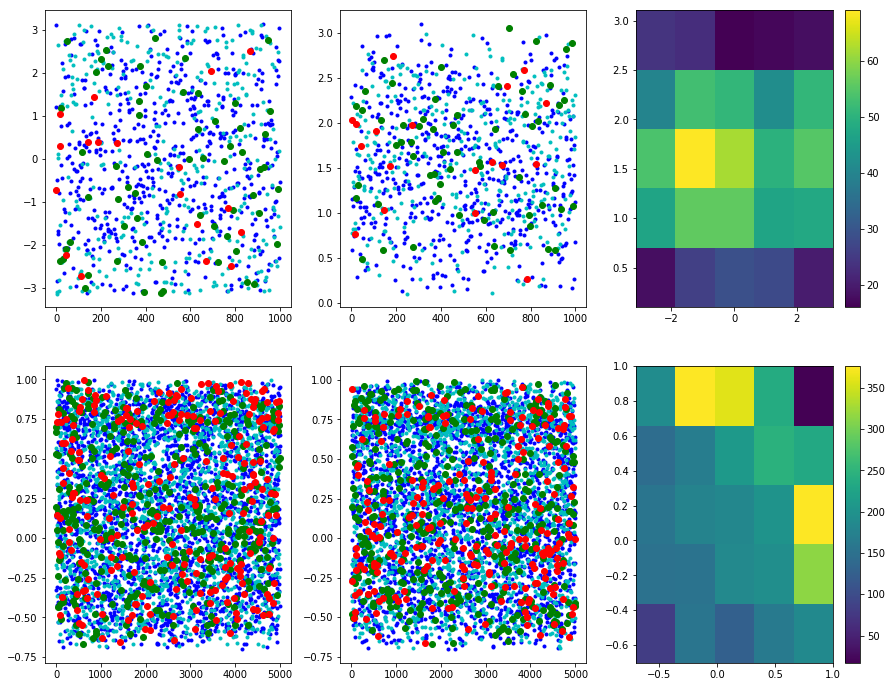

In [19]:
_ = plt.figure(figsize=(15,12))
_ = plt.subplot(2,3,1)
_ = plt.plot(idx_tp_n, featurevec_list_new[idx_tp_n,3], 'b.')
_ = plt.plot(idx_tn_n, featurevec_list_new[idx_tn_n,3], 'c.')
_ = plt.plot(idx_fp_n, featurevec_list_new[idx_fp_n,3], 'go')
_ = plt.plot(idx_fn_n, featurevec_list_new[idx_fn_n,3], 'ro')
_ = plt.subplot(2,3,2)
_ = plt.plot(idx_tp_n, featurevec_list_new[idx_tp_n,4], 'b.')
_ = plt.plot(idx_tn_n, featurevec_list_new[idx_tn_n,4], 'c.')
_ = plt.plot(idx_fp_n, featurevec_list_new[idx_fp_n,4], 'go')
_ = plt.plot(idx_fn_n, featurevec_list_new[idx_fn_n,4], 'ro')
_ = plt.subplot(2,3,3)
_ = plt.hist2d(featurevec_list_new[:,3], featurevec_list_new[:,4], bins=5)
_ = plt.colorbar()

_ = plt.subplot(2,3,4)
_ = plt.plot(idx_tp, featurevec_list[idx_tp,3], 'b.')
_ = plt.plot(idx_tn, featurevec_list[idx_tn,3], 'c.')
_ = plt.plot(idx_fp, featurevec_list[idx_fp,3], 'go')
_ = plt.plot(idx_fn, featurevec_list[idx_fn,3], 'ro')
_ = plt.subplot(2,3,5)
_ = plt.plot(idx_tp, featurevec_list[idx_tp,4], 'b.')
_ = plt.plot(idx_tn, featurevec_list[idx_tn,4], 'c.')
_ = plt.plot(idx_fp, featurevec_list[idx_fp,4], 'go')
_ = plt.plot(idx_fn, featurevec_list[idx_fn,4], 'ro')
_ = plt.subplot(2,3,6)
_ = plt.hist2d(featurevec_list[:,3], featurevec_list[:,4], bins=5)
_ = plt.colorbar()

IndexError: index 7 is out of bounds for axis 1 with size 7

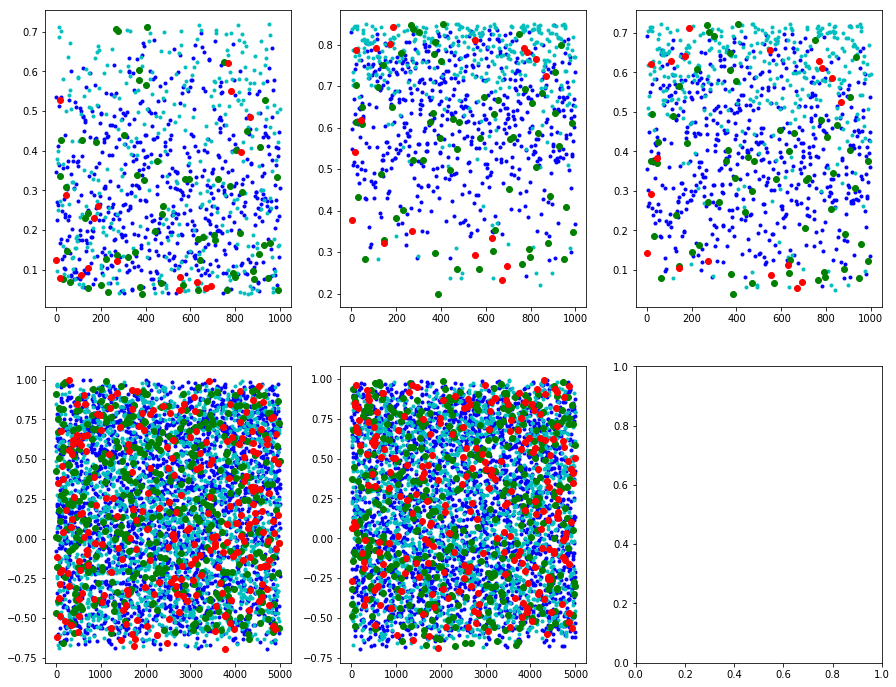

In [20]:
_ = plt.figure(figsize=(15,12))
_ = plt.subplot(2,3,1)
_ = plt.plot(idx_tp_n, featurevec_list_new[idx_tp_n,5], 'b.')
_ = plt.plot(idx_tn_n, featurevec_list_new[idx_tn_n,5], 'c.')
_ = plt.plot(idx_fp_n, featurevec_list_new[idx_fp_n,5], 'go')
_ = plt.plot(idx_fn_n, featurevec_list_new[idx_fn_n,5], 'ro')
_ = plt.subplot(2,3,2)
_ = plt.plot(idx_tp_n, featurevec_list_new[idx_tp_n,6], 'b.')
_ = plt.plot(idx_tn_n, featurevec_list_new[idx_tn_n,6], 'c.')
_ = plt.plot(idx_fp_n, featurevec_list_new[idx_fp_n,6], 'go')
_ = plt.plot(idx_fn_n, featurevec_list_new[idx_fn_n,6], 'ro')
_ = plt.subplot(2,3,3)
_ = plt.plot(idx_tp_n, featurevec_list_new[idx_tp_n,7], 'b.')
_ = plt.plot(idx_tn_n, featurevec_list_new[idx_tn_n,7], 'c.')
_ = plt.plot(idx_fp_n, featurevec_list_new[idx_fp_n,7], 'go')
_ = plt.plot(idx_fn_n, featurevec_list_new[idx_fn_n,7], 'ro')

_ = plt.subplot(2,3,4)
_ = plt.plot(idx_tp, featurevec_list[idx_tp,5], 'b.')
_ = plt.plot(idx_tn, featurevec_list[idx_tn,5], 'c.')
_ = plt.plot(idx_fp, featurevec_list[idx_fp,5], 'go')
_ = plt.plot(idx_fn, featurevec_list[idx_fn,5], 'ro')
_ = plt.subplot(2,3,5)
_ = plt.plot(idx_tp, featurevec_list[idx_tp,6], 'b.')
_ = plt.plot(idx_tn, featurevec_list[idx_tn,6], 'c.')
_ = plt.plot(idx_fp, featurevec_list[idx_fp,6], 'go')
_ = plt.plot(idx_fn, featurevec_list[idx_fn,6], 'ro')
_ = plt.subplot(2,3,6)
_ = plt.plot(idx_tp, featurevec_list[idx_tp,7], 'b.')
_ = plt.plot(idx_tn, featurevec_list[idx_tn,7], 'c.')
_ = plt.plot(idx_fp, featurevec_list[idx_fp,7], 'go')
_ = plt.plot(idx_fn, featurevec_list[idx_fn,7], 'ro')

In [ ]:
_ = plt.figure(figsize=(15,12))
_ = plt.subplot(2,2,1)
_ = plt.hist2d(featurevec_list_new[idx_tp_n,3], featurevec_list_new[idx_tp_n,4], bins=5)
_ = plt.colorbar()
_ = plt.subplot(2,2,2)
_ = plt.hist2d(featurevec_list_new[idx_tn_n,3], featurevec_list_new[idx_tn_n,4], bins=5)
_ = plt.colorbar()
_ = plt.subplot(2,2,3)
_ = plt.hist2d(featurevec_list_new[idx_fp_n,3], featurevec_list_new[idx_fp_n,4], bins=5)
_ = plt.colorbar()
_ = plt.subplot(2,2,4)
_ = plt.hist2d(featurevec_list_new[idx_fn_n,3], featurevec_list_new[idx_fn_n,4], bins=5)
_ = plt.colorbar()

In [ ]:
_ = plt.figure(figsize=(15,12))
_ = plt.subplot(2,2,1)
_ = plt.hist2d(featurevec_list[idx_tp,3], featurevec_list[idx_tp,4], bins=5)
_ = plt.colorbar()
_ = plt.subplot(2,2,2)
_ = plt.hist2d(featurevec_list[idx_tn,3], featurevec_list[idx_tn,4], bins=5)
_ = plt.colorbar()
_ = plt.subplot(2,2,3)
_ = plt.hist2d(featurevec_list[idx_fp,3], featurevec_list[idx_fp,4], bins=5)
_ = plt.colorbar()
_ = plt.subplot(2,2,4)
_ = plt.hist2d(featurevec_list[idx_fn,3], featurevec_list[idx_fn,4], bins=5)
_ = plt.colorbar()

## show distribution

In [ ]:
from pkg.utils.plot_utils import scatter_3d

In [ ]:
vec_list = []
for fvec in featurevec_list_new:
    mat = hori2mat(azimuth_loc=fvec[3], zenith=fvec[4], theta=0)
    vec_list.append(mat[:,2])
scatter_3d(vec_list)
plt.xlabel("x")
plt.ylabel("y")